# Lesson 15: Data wrangling demonstration

This notebook demonstrates key data wrangling techniques for handling missing data and outliers.

**1. Handling missing data**

- **Mean imputation**: Replace missing values with the column mean
- **Median imputation**: Replace missing values with the column median
- **KNN imputation**: Use K-Nearest Neighbors to estimate missing values
- **Iterative imputation**: Model each feature as a function of others (MICE algorithm)

**2. Detecting outliers**

- **IQR method**: Use interquartile range (Q3 - Q1) to identify outliers
- **Z-score method**: Identify values more than 3 standard deviations from the mean
- **Isolation Forest**: Machine learning algorithm that isolates anomalies
- **Local Outlier Factor (LOF)**: Density-based method comparing local density to neighbors

**3. Handling outliers**

- **Removal**: Remove outlier observations from the dataset
- **Capping (Winsorization)**: Replace outliers with boundary values (5th and 95th percentiles)
- **Binning (Discretization)**: Convert continuous values into discrete bins
- **Log transformation**: Apply logarithmic transformation to compress value range

## Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.gridspec import GridSpec
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.neighbors import LocalOutlierFactor

### Load datasets

In [2]:
df_original = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/salted_housing_data.csv')
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,NaN,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,NaN,565.0,2.181467,37.85,NaN,3.422


## 1. Handling missing data

We'll examine missing data in the `MedInc` (median income) feature and compare four imputation methods.

In [3]:
feature = 'MedInc'

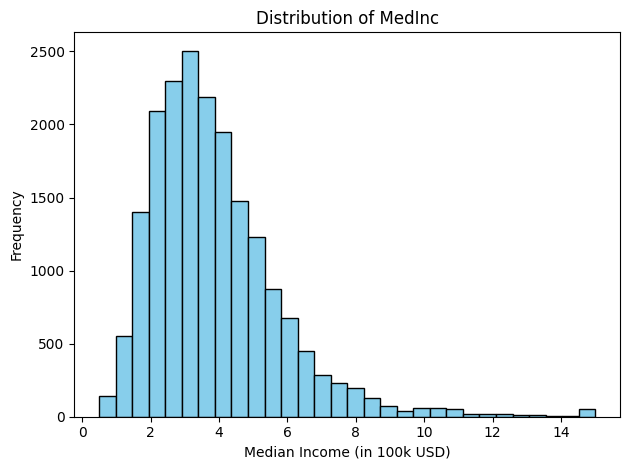

In [4]:
plt.title(f'Distribution of {feature}')

plt.hist(df[feature], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Median Income (in 100k USD)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### 1.1. Check for missing values

In [5]:
print(f'{feature} contains {df[feature].isnull().sum()} missing values.')

MedInc contains 1546 missing values.


### 1.2. Imputation methods

#### Mean imputation

In [6]:
df_mean = df.copy()
df_mean.fillna({feature: df_mean[feature].mean()}, inplace=True)

print(f"Mean imputation value: {df[feature].mean():.2f}")

Mean imputation value: 3.87


#### Median imputation

In [7]:
df_median = df.copy()
df_median.fillna({feature: df_median[feature].median()}, inplace=True)

print(f"Median imputation value: {df[feature].median():.2f}")

Median imputation value: 3.53


#### KNN imputation

Uses all features to find the 5 nearest neighbors and imputes missing values based on their feature values.

In [8]:
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_full = knn_imputer.fit_transform(df)

# Extract the feature of interest
df_knn = pd.DataFrame(
    df_knn_full[:, df.columns.get_loc(feature)],
    columns=[feature],
    index=df.index
)

print(f"KNN imputation uses 5 nearest neighbors across all {len(df.columns)} features")

KNN imputation uses 5 nearest neighbors across all 9 features


#### Iterative imputation

Models each feature as a function of others through multiple iterations, capturing multivariate relationships.

In [9]:
iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
df_iterative_full = iterative_imputer.fit_transform(df)

# Extract the feature of interest
df_iterative = pd.DataFrame(
    df_iterative_full[:, df.columns.get_loc(feature)],
    columns=[feature],
    index=df.index
)

print(f"Iterative imputation models relationships across all {len(df.columns)} features")

Iterative imputation models relationships across all 9 features


### 1.3. Compare imputation results

Visualize how each imputation method affects the distribution of `MedInc`.

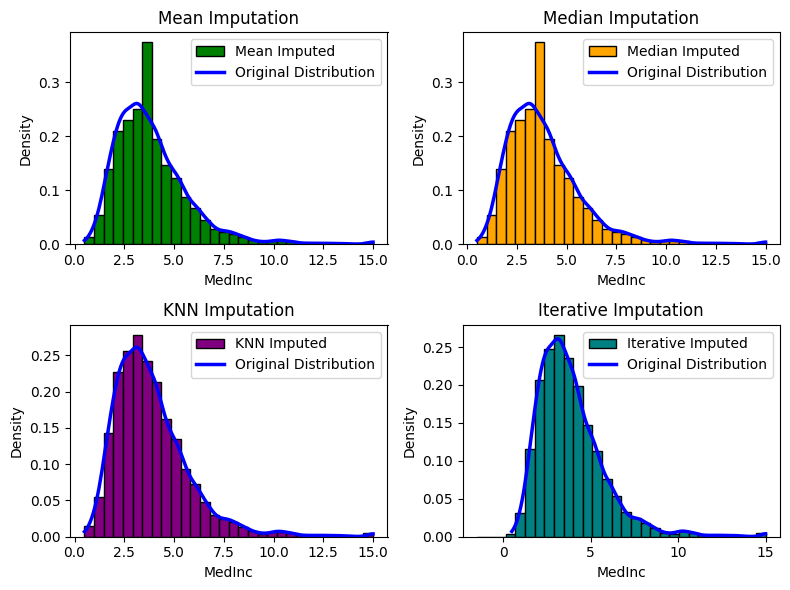

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

# Create KDE of original distribution
kde_original = stats.gaussian_kde(df[feature].dropna())
x_range = np.linspace(df[feature].min(), df[feature].max(), 200)
kde_values = kde_original(x_range)

# Define imputation methods and their properties
imputation_methods = [
    {'data': df_mean, 'title': 'Mean Imputation', 'color': 'green', 'label': 'Mean Imputed'},
    {'data': df_median, 'title': 'Median Imputation', 'color': 'orange', 'label': 'Median Imputed'},
    {'data': df_knn, 'title': 'KNN Imputation', 'color': 'purple', 'label': 'KNN Imputed'},
    {'data': df_iterative, 'title': 'Iterative Imputation', 'color': 'teal', 'label': 'Iterative Imputed'}
]

# Plot each imputation method
for idx, method in enumerate(imputation_methods):
    ax = axes[idx]
    
    ax.set_title(method['title'])
    ax.hist(
        method['data'][feature],
        bins=30, density=True,
        edgecolor='black', color=method['color'],
        label=method['label']
    )
    ax.plot(
        x_range, kde_values,
        'b-', linewidth=2.5,
        label='Original Distribution'
    )
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 2. Outlier detection methods

This section demonstrates four common methods for detecting outliers:

- **IQR method**: Use interquartile range (Q3 - Q1) to identify outliers
- **Z-score method**: Identify values more than 3 standard deviations from the mean
- **Isolation Forest**: Machine learning algorithm that isolates anomalies
- **Local Outlier Factor (LOF)**: Density-based method comparing local density to neighbors

We'll examine the `MedHouseVal` (median house value) feature to detect outliers using four different methods.

In [11]:
outlier_feature = 'MedHouseVal'

### 2.1. Visualize feature distribution

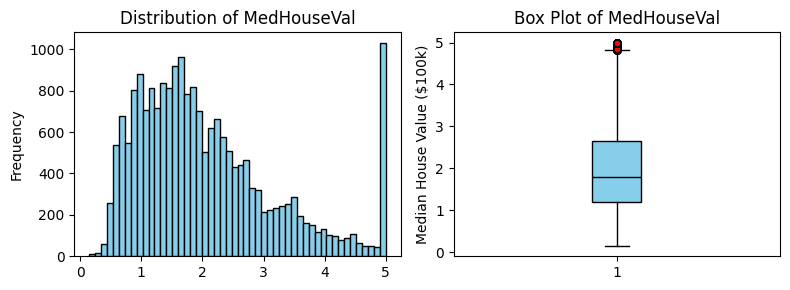

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Histogram
axes[0].set_title(f'Distribution of {outlier_feature}')

axes[0].hist(
    df_original[outlier_feature],
    bins=50,
    color='skyblue',
    edgecolor='black',
)

axes[0].set_xlabel('Median House Value ($100k)')
axes[0].set_ylabel('Frequency')

# Box plot
axes[1].set_title(f'Box Plot of {outlier_feature}')

axes[1].boxplot(
    df_original[outlier_feature],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor='skyblue'),
    medianprops=dict(color='black'),
    flierprops=dict(marker='o', markerfacecolor='red', markersize=5)
)

axes[1].set_ylabel('Median House Value ($100k)')
axes[0].set_xlabel('')

plt.tight_layout()
plt.show()

### 2.2. IQR (interquartile range) method

Defines outliers as values below Q1 - 1.5×IQR or above Q3 + 1.5×IQR.

In [13]:
def detect_outliers_iqr(data, column, multiplier=1.5):
    """
    Detect outliers using the IQR method.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - multiplier: IQR multiplier (typically 1.5 for outliers, 3.0 for extreme outliers)
    
    Returns:
    - Boolean series indicating outliers
    """

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    
    return outliers

outliers_iqr = detect_outliers_iqr(df_original, outlier_feature)

### 2.3. Z-score method

Identifies outliers as values with |z-score| > 3, meaning they are more than 3 standard deviations from the mean.

In [14]:
def detect_outliers_zscore(data, column, threshold=3):
    """
    Detect outliers using the Z-Score method.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - threshold: z-score threshold (typically 3)
    
    Returns:
    - Boolean series indicating outliers
    """

    mean = data[column].mean()
    std = data[column].std()
    z_scores = np.abs((data[column] - mean) / std)
    
    outliers = z_scores > threshold
    
    return outliers

outliers_zscore = detect_outliers_zscore(df_original, outlier_feature)

### 2.4. Isolation Forest

Machine learning algorithm designed for anomaly detection that randomly partitions data to identify points that are quickly isolated.

In [15]:
def detect_outliers_isolation_forest(data, column, contamination=0.05):
    """
    Detect outliers using Isolation Forest.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - contamination: expected proportion of outliers (default 0.05 = 5%)
    
    Returns:
    - Boolean series indicating outliers
    """
    # Isolation Forest requires 2D array
    X = data[[column]].values
    
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    predictions = iso_forest.fit_predict(X)
    
    # Isolation Forest returns -1 for outliers, 1 for inliers
    outliers = predictions == -1
    
    return outliers

outliers_iforest = detect_outliers_isolation_forest(df_original, outlier_feature)

### 2.5. Local Outlier Factor (LOF)

Identifies outliers by measuring local density deviation relative to neighbors. Points with substantially lower density than their neighbors are flagged as outliers.

In [16]:
def detect_outliers_lof(data, column, n_neighbors=1000):
    """
    Detect outliers using Local Outlier Factor.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - n_neighbors: number of neighbors to consider (default 1000)
    
    Returns:
    - Boolean series indicating outliers
    """

    # LOF requires 2D array
    X = data[[column]].values
    
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    predictions = lof.fit_predict(X)
    
    # LOF returns -1 for outliers, 1 for inliers
    outliers = predictions == -1

    return outliers

outliers_lof = detect_outliers_lof(df_original, outlier_feature)

### 2.6. Compare outlier detection methods

Visualize how each method identifies outliers in the `MedHouseVal` feature.

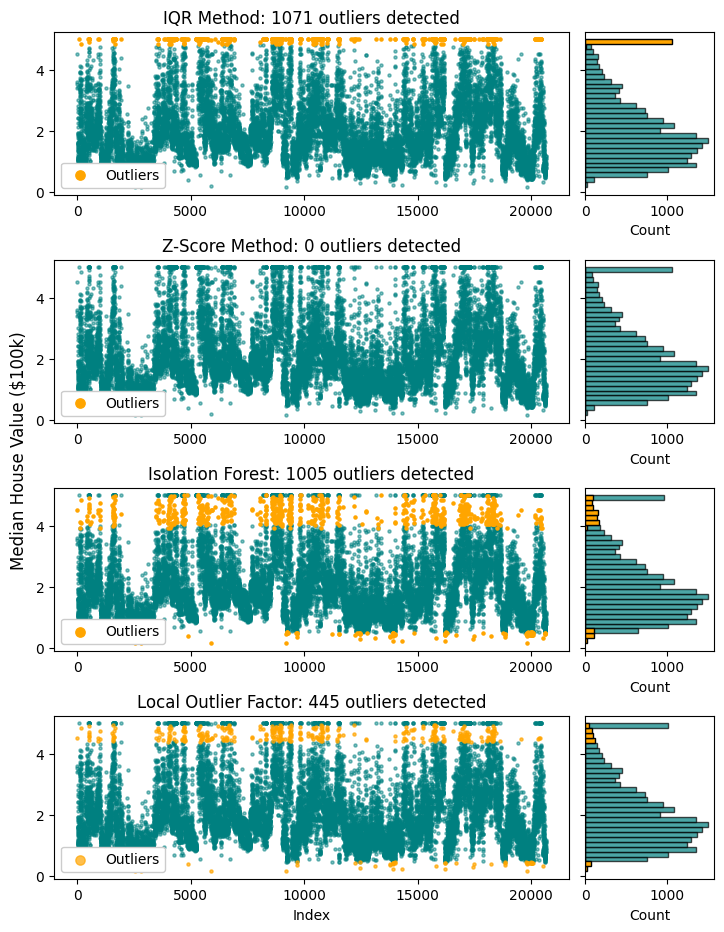

In [17]:
# Precompute 30 bins for consistent histogram display across all methods
n_hist_bins = 30

hist_bins = np.linspace(
    df_original[outlier_feature].min(), 
    df_original[outlier_feature].max(), 
    n_hist_bins + 1
)

fig = plt.figure(figsize=(8, 11))
gs = GridSpec(4, 2, figure=fig, width_ratios=[4, 1], hspace=0.4, wspace=0.05)
fig.supylabel('Median House Value ($100k)')

# Define detection methods
detection_methods = [
    {'outliers': outliers_iqr, 'title': 'IQR Method'},
    {'outliers': outliers_zscore, 'title': 'Z-Score Method'},
    {'outliers': outliers_iforest, 'title': 'Isolation Forest'},
    {'outliers': outliers_lof, 'title': 'Local Outlier Factor'}
]

# Plot each detection method
for idx, method in enumerate(detection_methods):
    outliers = method['outliers']
    
    # Scatter plot
    ax_scatter = fig.add_subplot(gs[idx, 0])
    ax_scatter.set_title(f"{method['title']}: {outliers.sum()} outliers detected")
    
    ax_scatter.scatter(
        df_original.index[~outliers],
        df_original.loc[~outliers, outlier_feature], 
        c='teal', alpha=0.5, s=5
    )
    
    ax_scatter.scatter(
        df_original.index[outliers],
        df_original.loc[outliers, outlier_feature], 
        c='orange', alpha=0.7 if idx == 3 else 1.0, s=5, label='Outliers'
    )
    
    if idx == 3:  # Last plot gets x-label
        ax_scatter.set_xlabel('Index')
    ax_scatter.set_ylabel('')
    ax_scatter.legend(loc='lower left', framealpha=1, markerscale=3)
    
    # Histogram
    ax_hist = fig.add_subplot(gs[idx, 1], sharey=ax_scatter)
    ax_hist.hist(
        df_original.loc[~outliers, outlier_feature],
        bins=hist_bins, orientation='horizontal', 
        color='teal', alpha=0.7, edgecolor='black'
    )
    
    ax_hist.hist(
        df_original.loc[outliers, outlier_feature],
        bins=hist_bins, orientation='horizontal', 
        color='orange', edgecolor='black'
    )
    
    ax_hist.tick_params(labelleft=False)
    ax_hist.set_xlabel('Count', fontsize=10)

plt.subplots_adjust(left=0.075)
plt.show()

## 3. Handling outliers

Once outliers are detected, we must decide how to handle them. This section demonstrates four common approaches:

- **Removal**: Remove outlier observations from the dataset
- **Capping (Winsorization)**: Replace outliers with boundary values (5th and 95th percentiles)
- **Binning (Discretization)**: Convert continuous values into discrete bins
- **Log transformation**: Apply logarithmic transformation to compress value range

### 3.1. Removal

Remove outliers identified by the IQR method from the dataset.

In [18]:
# Method 1: Remove outliers
df_removed = df_original[~outliers_iqr].copy()

### 3.2. Capping (Winsorization)

Cap outliers at the 5th and 95th percentiles, preserving sample size while limiting extreme values.

In [19]:
# Method 2: Cap outliers at percentiles
lower_percentile = df_original[outlier_feature].quantile(0.05)
upper_percentile = df_original[outlier_feature].quantile(0.95)

df_capped = df_original.copy()
df_capped[outlier_feature] = df_capped[outlier_feature].clip(lower=lower_percentile, upper=upper_percentile)

# Count how many values were capped
n_capped_lower = (df_original[outlier_feature] < lower_percentile).sum()
n_capped_upper = (df_original[outlier_feature] > upper_percentile).sum()

### 3.3. Binning (discretization)

Convert continuous values into 10 discrete bins, reducing outlier impact by grouping extreme values with similar values.

In [20]:
# Method 3: Binning into 30 equal-width bins
df_binned = df_original.copy()

# Create 10 equal-width bins
n_bins = 10

# Store the binned result to extract bin edges
binned_result, bin_edges = pd.cut(
    df_binned[outlier_feature], 
    bins=n_bins, 
    include_lowest=True,
    retbins=True
)

df_binned[f'{outlier_feature}_binned'] = binned_result

# Convert to numeric for statistical comparison
df_binned[f'{outlier_feature}_binned_numeric'] = pd.cut(
    df_binned[outlier_feature], 
    bins=n_bins, 
    labels=range(1, n_bins + 1), 
    include_lowest=True
).astype(int)

### 3.4. Log transformation

Apply log(1 + x) transformation to compress the value range and reduce outlier impact.

In [21]:
# Method 4: Log transformation
df_log = df_original.copy()

# Apply log1p transformation (log(1 + x)) to handle zeros
df_log[f'{outlier_feature}_log'] = np.log1p(df_log[outlier_feature])

### 3.5. Compare outlier handling methods

Visualize how each method affects the distribution of `MedHouseVal`, with the original distribution overlaid for comparison.

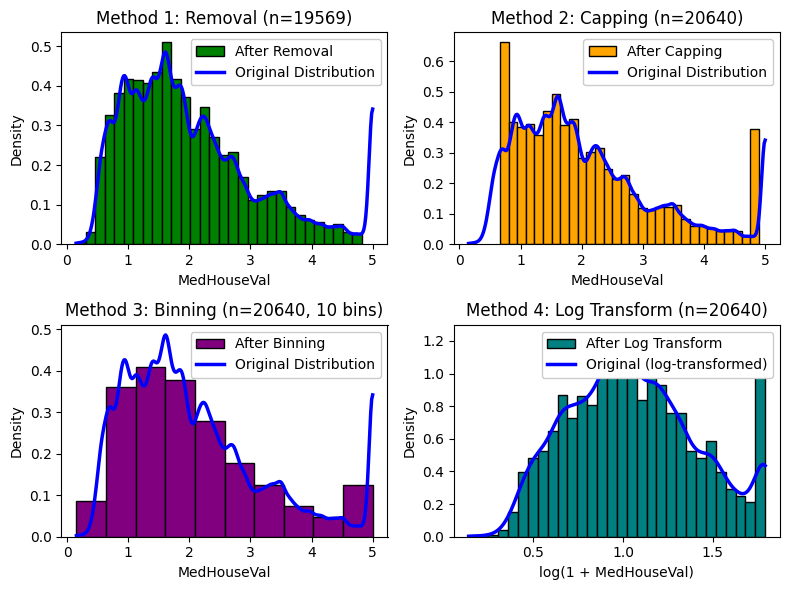

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

# Create KDE of original distribution with small bandwidth to preserve outlier spike
kde_original = stats.gaussian_kde(df_original[outlier_feature].dropna(), bw_method=0.05)
x_range = np.linspace(df_original[outlier_feature].min(), df_original[outlier_feature].max(), 300)
kde_values = kde_original(x_range)

# Create KDE for log-transformed original distribution
kde_original_log = stats.gaussian_kde(np.log1p(df_original[outlier_feature].dropna()), bw_method=0.15)
x_range_log = np.linspace(df_log[f'{outlier_feature}_log'].min(), df_log[f'{outlier_feature}_log'].max(), 300)
kde_values_log = kde_original_log(x_range_log)

# Define handling methods
handling_methods = [
    {'data': df_removed[outlier_feature], 'title': f'Method 1: Removal (n={len(df_removed)})', 
     'color': 'green', 'label': 'After Removal', 'bins': 30, 
     'x_range': x_range, 'kde_values': kde_values, 'xlabel': outlier_feature},
    {'data': df_capped[outlier_feature], 'title': f'Method 2: Capping (n={len(df_capped)})', 
     'color': 'orange', 'label': 'After Capping', 'bins': 30,
     'x_range': x_range, 'kde_values': kde_values, 'xlabel': outlier_feature},
    {'data': df_binned[outlier_feature], 'title': f'Method 3: Binning (n={len(df_binned)}, {n_bins} bins)', 
     'color': 'purple', 'label': 'After Binning', 'bins': bin_edges,
     'x_range': x_range, 'kde_values': kde_values, 'xlabel': outlier_feature},
    {'data': df_log[f'{outlier_feature}_log'], 'title': f'Method 4: Log Transform (n={len(df_log)})', 
     'color': 'teal', 'label': 'After Log Transform', 'bins': 30,
     'x_range': x_range_log, 'kde_values': kde_values_log, 'xlabel': f'log(1 + {outlier_feature})'}
]

# Plot each handling method
for idx, method in enumerate(handling_methods):
    ax = axes[idx]
    
    ax.set_title(method['title'])
    ax.hist(
        method['data'],
        bins=method['bins'], edgecolor='black', color=method['color'],
        density=True, label=method['label']
    )
    
    ax.plot(
        method['x_range'], method['kde_values'],
        'b-', linewidth=2.5,
        label='Original (log-transformed)' if idx == 3 else 'Original Distribution'
    )
    
    ax.set_xlabel(method['xlabel'])
    ax.set_ylabel('Density')
    ax.legend(loc='upper right', framealpha=1, markerscale=3)

plt.tight_layout()
plt.show()